In [13]:
# Import and Install Libraries

from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
)
import torch, torchinfo
import monai
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet, LocalNet, RegUNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset
import torch.nn.functional as F

from glob import glob
import cv2
import torchmetrics

from torch.autograd import Variable

from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import zoom
import pandas as pd

import torch.nn as nn

import numpy as np
import torch
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation
import os
import tempfile
from monai.losses import *
from monai.metrics import *
from piqa import SSIM

import nibabel as nib

import csv

print_config()
set_determinism(40)

MONAI version: 1.0.1
Numpy version: 1.22.3
Pytorch version: 1.13.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /home/mkh/anaconda3/envs/phd/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.0.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.12.0
gdown version: 4.6.4
TorchVision version: 0.14.1
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [14]:
print('How many GPUs = ' + str(torch.cuda.device_count()))

#checking for device

device=torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)


if not torch.cuda.is_available():
    raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

How many GPUs = 4
cuda:2
device name NVIDIA GeForce RTX 3090 Ti


In [15]:
img_size = 256
slice_size = 32
EP = 30
num_workers = 8

TrDir = "/home/mkh/MKH/KSA/VAE_3D/data_VAE_3D/train/"
ValDir = "/home/mkh/MKH/KSA/VAE_3D/data_VAE_3D/val/"

TrNames = sorted(os.listdir(TrDir))
ValNames = sorted(os.listdir((ValDir)))

TrImage = []
ValImage = []

for name in TrNames:
    path = os.path.join(TrDir, name)
    TrImage.append(path)

for name in ValNames:
    path = os.path.join(ValDir, name)
    ValImage.append(path)

In [16]:
print(len(TrImage))
print(len(ValImage))

1356
66


In [17]:
class EchoDatasetMask(Dataset):
    def __init__(self, images_path, labtozero):

        self.images_path = images_path
        self.labtozero = labtozero
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        # image = cv2.imread(self.images_path[index], cv2.IMREAD_GRAYSCALE)
        img_3d = nib.load(self.images_path[index])
        image = img_3d.get_fdata()
        image[image==127]=1 #lv
        image[image==255]=2 #myo
        if self.labtozero is not None:
            image [image==self.labtozero]=0
            
        # image = cv2.resize(image,(img_size, img_size), interpolation=cv2.INTER_NEAREST)
        image = zoom(image, (img_size / image.shape[0], img_size / image.shape[1], slice_size / image.shape[2]), order=0)
        image = image/(image.max()) ## (512, 512, 3)
#         print(image.max())
#         image = image/(image.max()) ## (512, 512, 3)
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        self.images_path[index]
        return image

    def __len__(self):
        return self.n_samples
    
def get_batches_mask(_dir,
                     _labtozero,
                     batch_size,
                     num_workers,
                     pin_memory):
    
    _data = EchoDatasetMask(images_path=_dir, labtozero = _labtozero)

    _loader = DataLoader(_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              pin_memory=pin_memory,
                              shuffle=True)

    return _loader

print(len(sorted(TrImage)))
print(len(sorted(ValImage)))

1356
66


_train_mask_ shape: torch.Size([256, 256, 32])
_val_mask_ shape: torch.Size([256, 256, 32])
_train_mask_ range: 1.0 0.0 [0. 1.]
_val_mask_ range: 1.0 0.0 [0. 1.]


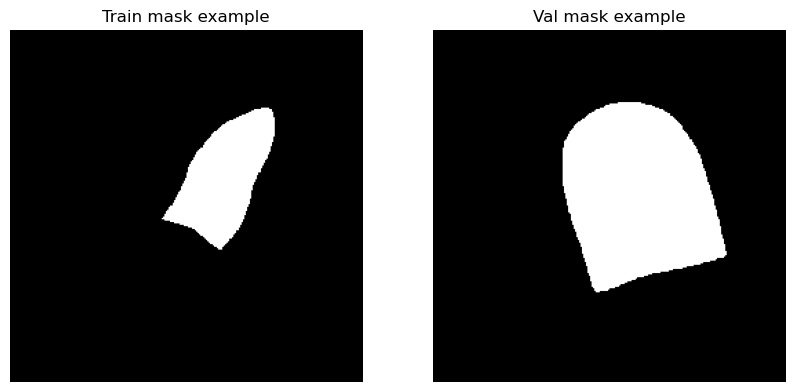

In [18]:
train_mask_LV = get_batches_mask(_dir = sorted(TrImage),
                                            _labtozero = 2,
                                            batch_size = 32,
                                            num_workers = num_workers,
                                            pin_memory = True)



val_mask_LV = get_batches_mask(_dir = sorted(ValImage),
                                          _labtozero = 2,
                                          batch_size = 8,
                                          num_workers = num_workers,
                                          pin_memory = True)

dataloaders = {'_train': train_mask_LV, '_val': val_mask_LV}


_train_mask_ = first(dataloaders["_train"])[0][0]
_val_mask_ = first(dataloaders["_val"])[0][0]

print(f"_train_mask_ shape: {_train_mask_.shape}")
print(f"_val_mask_ shape: {_val_mask_.shape}")


print(f"_train_mask_ range: {_train_mask_.max()} {_train_mask_.min()} {np.unique(_train_mask_)}")
print(f"_val_mask_ range: {_val_mask_.max()} {_val_mask_.min()} {np.unique(_val_mask_)}")

plt.figure("check", (10, 5))

plt.subplot(1, 2, 1)
plt.title("Train mask example")
plt.imshow(_train_mask_[:,:,20], cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Val mask example")
plt.imshow(_val_mask_[:,:,20], cmap="gray")
plt.axis('off')

plt.show()

_train_mask_ shape: torch.Size([256, 256, 32])
_val_mask_ shape: torch.Size([256, 256, 32])
_train_mask_ range: 1.0 0.0 [0. 1.]
_val_mask_ range: 1.0 0.0 [0. 1.]


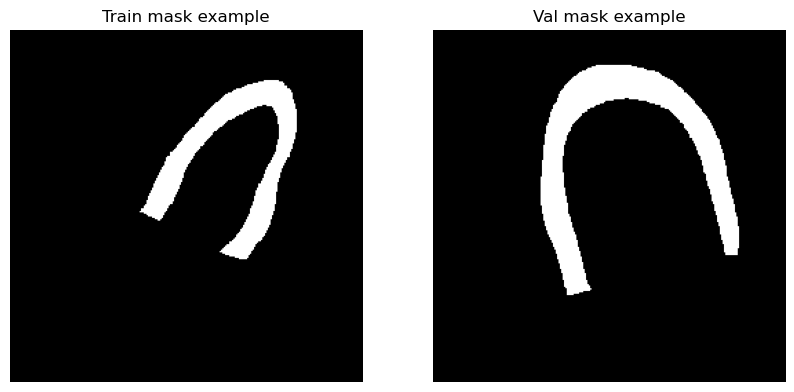

In [19]:
train_mask_Myo = get_batches_mask(_dir = sorted(TrImage),
                                            _labtozero = 1,
                                            batch_size = 8,
                                            num_workers = num_workers,
                                            pin_memory = True)



val_mask_Myo = get_batches_mask(_dir = sorted(ValImage),
                                          _labtozero = 1,
                                          batch_size = 8,
                                          num_workers = num_workers,
                                          pin_memory = True)

dataloaders = {'_train': train_mask_Myo, '_val': val_mask_Myo}


_train_mask_ = first(dataloaders["_train"])[0][0]
_val_mask_ = first(dataloaders["_val"])[0][0]

print(f"_train_mask_ shape: {_train_mask_.shape}")
print(f"_val_mask_ shape: {_val_mask_.shape}")


print(f"_train_mask_ range: {_train_mask_.max()} {_train_mask_.min()} {np.unique(_train_mask_)}")
print(f"_val_mask_ range: {_val_mask_.max()} {_val_mask_.min()} {np.unique(_val_mask_)}")

plt.figure("check", (10, 5))

plt.subplot(1, 2, 1)
plt.title("Train mask example")
plt.imshow(_train_mask_[:,:,20], cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Val mask example")
plt.imshow(_val_mask_[:,:,20], cmap="gray")
plt.axis('off')

plt.show()

In [20]:
trainData = {'Myo': train_mask_Myo, 'LV': train_mask_LV}
valData = {'Myo': val_mask_Myo, 'LV': val_mask_LV}

In [21]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm3d(16)
        self.conv3 = nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1)
        self.linear1 = nn.Linear(img_size//8 * img_size//8 * slice_size//8 * 32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)  # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1/2).sum()
        return z


In [22]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, img_size // 8 * img_size // 8 * slice_size // 8 * 32),
            nn.ReLU(True)
        )
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, img_size // 8, img_size // 8, slice_size // 8))
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(True),
            nn.ConvTranspose3d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm3d(8),
            nn.ReLU(True),
            nn.ConvTranspose3d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
    
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [23]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
#         print(f'Latent dim = {z.shape}')
#         print(f'Latent Value = {z}')
        return self.decoder(z)

In [24]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 8


# torchinfo.summary(Myo_VAE, input_size=(2, 1, 512, 512), depth=100)

LV_VAE = VariationalAutoencoder(latent_dims=d)
LV_VAE.to(device)
LV_VAE.load_state_dict(torch.load('LV_VAE_3D_'+ str(img_size) + '_' + str(slice_size) + '_.pth', map_location= device))

torchinfo.summary(LV_VAE, input_size=(2, 1, img_size, img_size, slice_size), depth=100)

Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoencoder                   [2, 1, 256, 256, 32]      --
├─VariationalEncoder: 1-1                [2, 8]                    --
│    └─Conv3d: 2-1                       [2, 8, 128, 128, 16]      224
│    └─Conv3d: 2-2                       [2, 16, 64, 64, 8]        3,472
│    └─BatchNorm3d: 2-3                  [2, 16, 64, 64, 8]        32
│    └─Conv3d: 2-4                       [2, 32, 32, 32, 4]        13,856
│    └─Linear: 2-5                       [2, 128]                  16,777,344
│    └─Linear: 2-6                       [2, 8]                    1,032
│    └─Linear: 2-7                       [2, 8]                    1,032
├─Decoder: 1-2                           [2, 1, 256, 256, 32]      --
│    └─Sequential: 2-8                   [2, 131072]               --
│    │    └─Linear: 3-1                  [2, 128]                  1,152
│    │    └─ReLU: 3-2                    [2, 128]           

In [25]:
lr = 1e-3 

optim_LV_VAE = torch.optim.Adam(LV_VAE.parameters(), lr=lr, weight_decay=1e-5)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

In [26]:
### Training function

class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)
    

label_SSIM = SSIMLoss(n_channels=1).to(device) # .cuda() if you need GPU support

label_loss = DiceLoss()


def train_epoch(model, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    _loss = 0.0
    _loss_DSC = 0.0
    _loss_SSIM = 0.0
    _loss_KL = 0.0
    _loss_diff_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = model(x)
        # Evaluate loss
        # x_o = x[8,:,:,:].reshape(512,512)
        # x_p = x_hat[8,:,:,:].reshape(512,512)

        # x_p[x_p<0.1]=0
        # x_p[x_p>0.9]=1


        # # print(x_o.shape)
        # # print(x_p.shape)
        # print(torch.unique(x_o, return_counts= True))
        # print(torch.unique(x_p, return_counts= True))
        
        diff_loss = ((x - x_hat)**2).sum()
        DSC = label_loss(x, x_hat)
        KL = model.encoder.kl
        SSIM = label_SSIM(x,x_hat)
        
        loss = 2*KL + 2*diff_loss + DSC + SSIM
    
#         print('------')
#         print(DSC)    
#         print(SSIM)
#         print(KL)
#         print(diff_loss)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.item()))
        _loss+=loss.item()
        _loss_DSC+=DSC.item()
        _loss_SSIM+=SSIM.item()
        _loss_KL+=KL.item()
        _loss_diff_loss+=diff_loss.item()
        
        dice_metric(y_pred = x_hat, y=x)
            
    metric = dice_metric.aggregate().item()
    dice_metric.reset()
    print(f"Train mean dice: {metric:.4f}")
    L = len(dataloader.dataset)
#     print(_loss_DSC)
#     print(_loss_SSIM)

    return [_loss/L, _loss_DSC/L, _loss_SSIM/L, _loss_KL/L, _loss_diff_loss/L]

In [27]:
### Testing function
def test_epoch(model, device, dataloader):
    
    # Set evaluation mode for encoder and decoder
    model.eval()
    _loss = 0.0
    _loss_DSC = 0.0
    _loss_SSIM = 0.0
    _loss_KL = 0.0
    _loss_diff_loss = 0.0
    
    with torch.no_grad(): # No need to track the gradients
        for x in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = model.encoder(x)
            # Decode data
            x_hat = model(x)         
            
            diff_loss = ((x - x_hat)**2).sum()
            DSC = label_loss(x, x_hat)
            KL = model.encoder.kl
            SSIM = label_SSIM(x,x_hat)

            loss = 2*KL + 2*diff_loss + DSC + SSIM
            
            _loss += loss.item()
            _loss_DSC+=DSC.item()
            _loss_SSIM+=SSIM.item()
            _loss_KL+=KL.item()
            _loss_diff_loss+=diff_loss.item()

        #     meandice_.extend((compute_meandice(y_pred = make_one_hot(x_hat, C=3), y=make_one_hot(x.to(device), C=3))).detach().cpu().numpy())
            
            dice_metric(y_pred = x_hat, y=x)
            
        metric = dice_metric.aggregate().item()
        dice_metric.reset()
        print(f"Val mean dice: {metric:.4f}")
        L = len(dataloader.dataset)
        # print(f'Mean dice = {np.mean(np.array(meandice_), axis=0)}')

    return [_loss/L, _loss_DSC/L, _loss_SSIM/L, _loss_KL/L, _loss_diff_loss/L, metric]

In [28]:
def plot_outputs(encoder, decoder, mask):
    plt.figure(figsize=(16,4.5))
    for image in mask:
#         print(image.size(0))
        encoder.eval() 
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(image.to(device)))
            
            
        for i in range (image.size(0)):
            ax = plt.subplot(2,image.size(0),i+1)
            plt.imshow(image[i,:,:,:,20].reshape(img_size, img_size).cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == image.size(0)//2:
                ax.set_title('Original images')
                
#             print(np.unique(rec_img[i,:,:,:].reshape(512,512).cpu().squeeze().numpy()))
                
            ax = plt.subplot(2, image.size(0), i + 1 + image.size(0))
            plt.imshow(rec_img[i,:,:,:,20].reshape(img_size, img_size).cpu().squeeze().numpy(), cmap='gist_gray')  
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            # print(np.unique(rec_img[i,:,:,:].reshape(512,512).cpu().squeeze().numpy()))
            if i == image.size(0)//2:
                ax.set_title('Reconstructed images')
                
        plt.show()   
        break    


<<<----------------------- EPOCH 1/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>


y_pred should be a binarized tensor.


Train mean dice: 0.9590
Val mean dice: 0.6232
Valid DSC improved from 0.0000 to 0.6232! Best model is saving as---> LV_VAE_3D_v2_256_32_.pth

 LV train loss=4810.284 	 and 	 LV val loss=160012.515
Best val DSC: 0.6232 at epoch number of 1


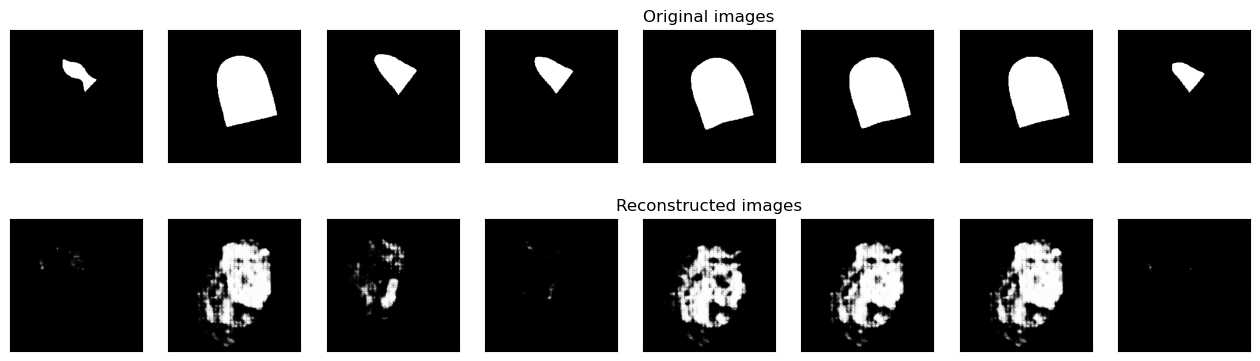


<<<----------------------- EPOCH 2/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9609
Val mean dice: 0.6151

 LV train loss=4258.113 	 and 	 LV val loss=156339.166
Best val DSC: 0.6232 at epoch number of 1


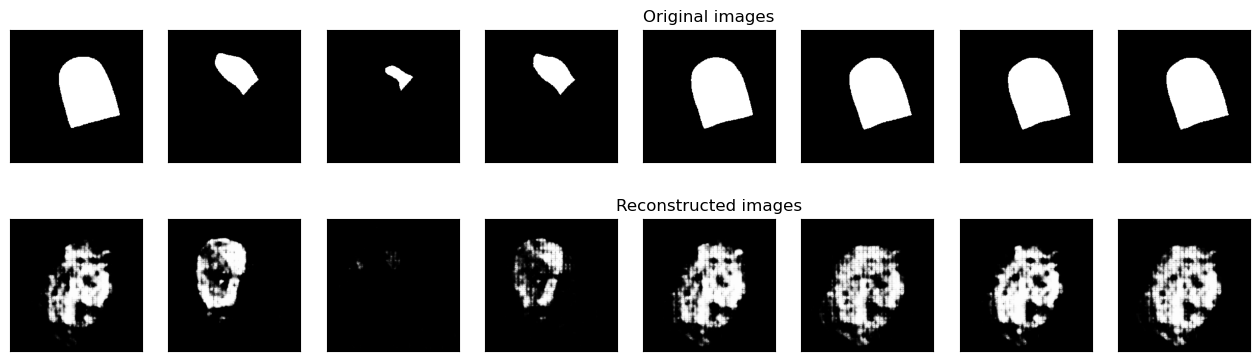


<<<----------------------- EPOCH 3/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9619
Val mean dice: 0.6172

 LV train loss=4289.948 	 and 	 LV val loss=149325.508
Best val DSC: 0.6232 at epoch number of 1


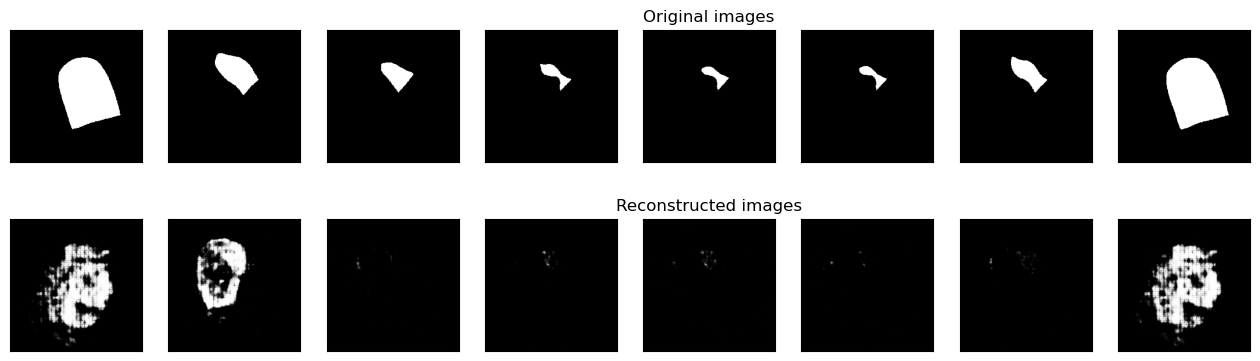


<<<----------------------- EPOCH 4/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9625
Val mean dice: 0.6284
Valid DSC improved from 0.6232 to 0.6284! Best model is saving as---> LV_VAE_3D_v2_256_32_.pth

 LV train loss=4158.525 	 and 	 LV val loss=159150.436
Best val DSC: 0.6284 at epoch number of 4


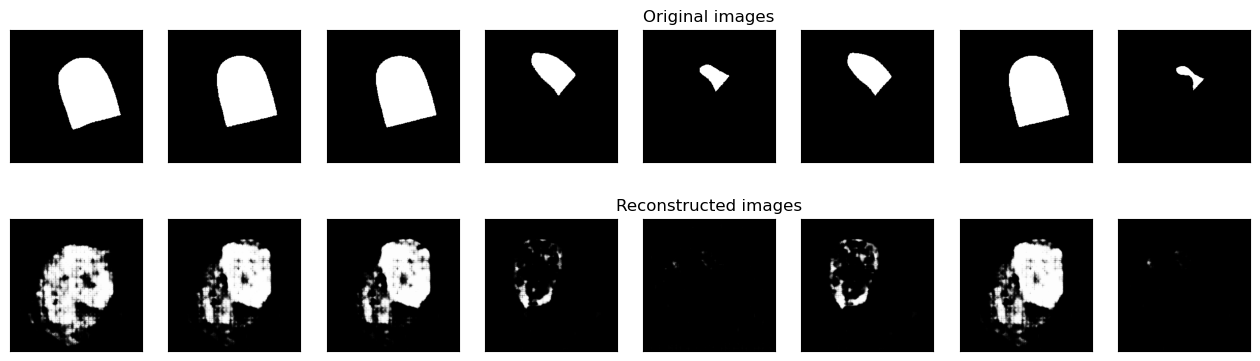


<<<----------------------- EPOCH 5/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9636
Val mean dice: 0.6132

 LV train loss=3937.847 	 and 	 LV val loss=162633.874
Best val DSC: 0.6284 at epoch number of 4


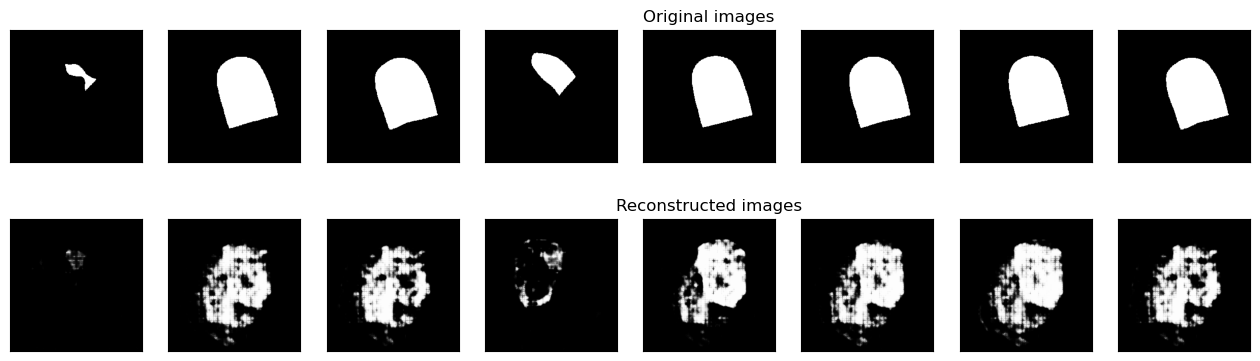


<<<----------------------- EPOCH 6/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9642
Val mean dice: 0.6269

 LV train loss=3819.702 	 and 	 LV val loss=165034.019
Best val DSC: 0.6284 at epoch number of 4


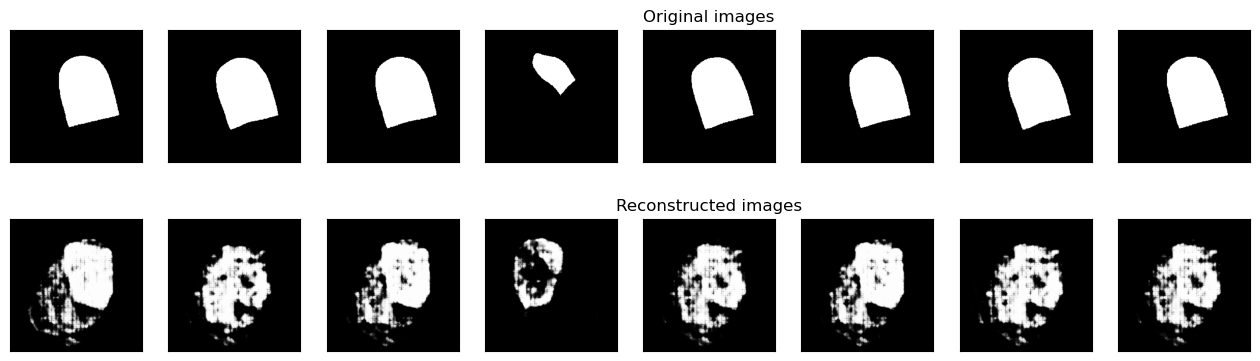


<<<----------------------- EPOCH 7/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9650
Val mean dice: 0.6380
Valid DSC improved from 0.6284 to 0.6380! Best model is saving as---> LV_VAE_3D_v2_256_32_.pth

 LV train loss=3728.833 	 and 	 LV val loss=148629.950
Best val DSC: 0.6380 at epoch number of 7


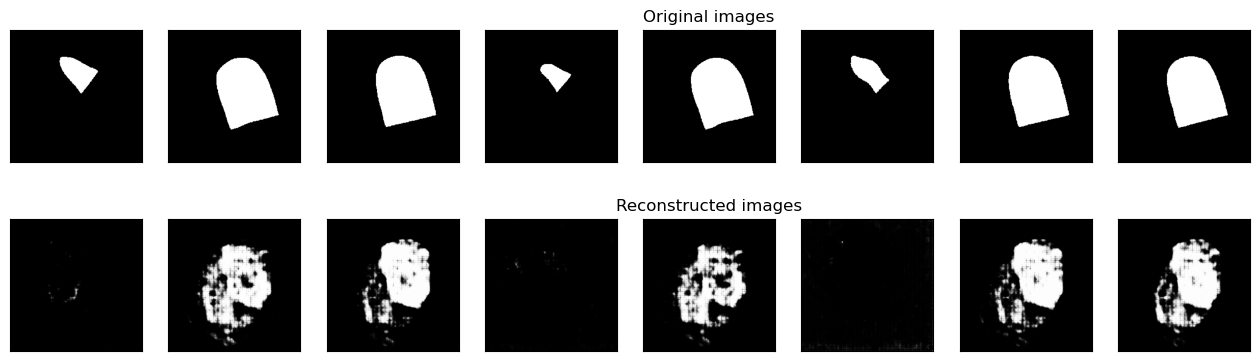


<<<----------------------- EPOCH 8/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9657
Val mean dice: 0.6362

 LV train loss=3670.773 	 and 	 LV val loss=159173.808
Best val DSC: 0.6380 at epoch number of 7


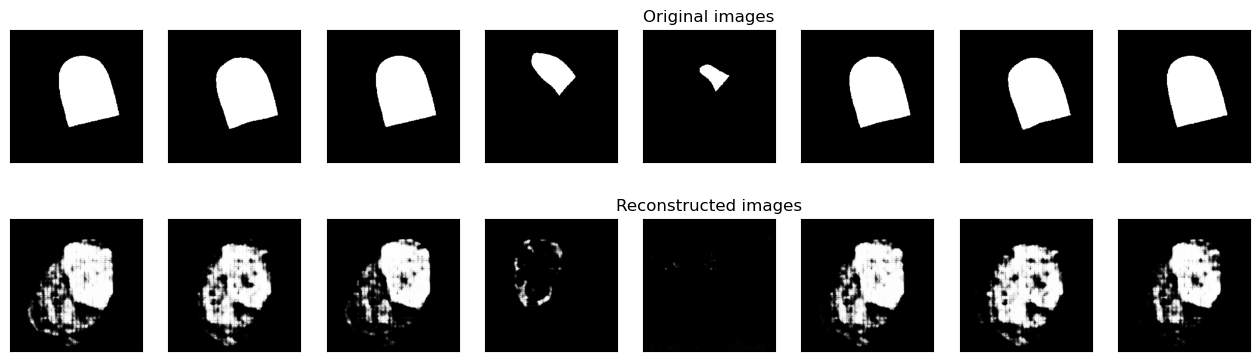


<<<----------------------- EPOCH 9/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9664
Val mean dice: 0.6184

 LV train loss=3516.156 	 and 	 LV val loss=161209.151
Best val DSC: 0.6380 at epoch number of 7


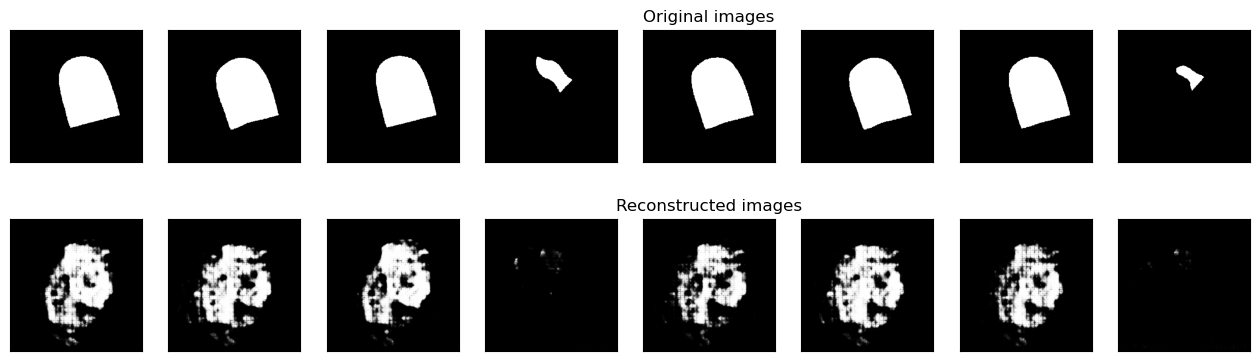


<<<----------------------- EPOCH 10/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9666
Val mean dice: 0.6460
Valid DSC improved from 0.6380 to 0.6460! Best model is saving as---> LV_VAE_3D_v2_256_32_.pth

 LV train loss=3644.304 	 and 	 LV val loss=152998.739
Best val DSC: 0.6460 at epoch number of 10


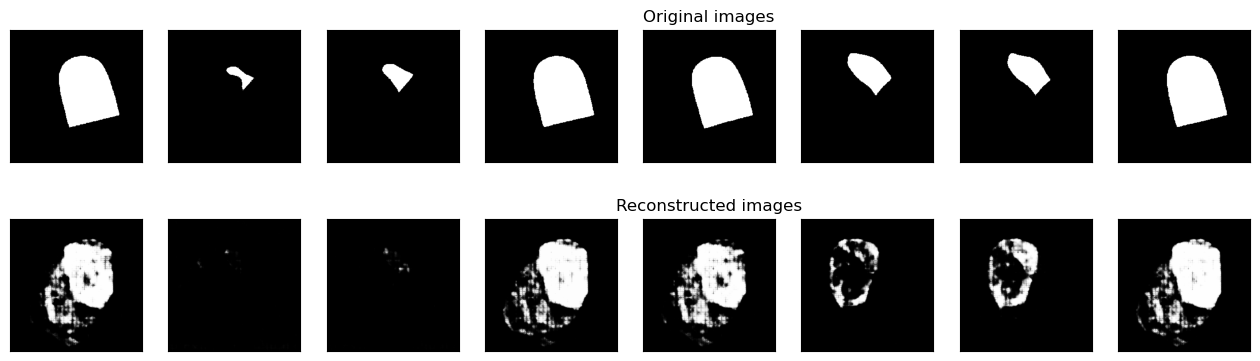


<<<----------------------- EPOCH 11/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9677
Val mean dice: 0.6384

 LV train loss=3589.522 	 and 	 LV val loss=154543.609
Best val DSC: 0.6460 at epoch number of 10


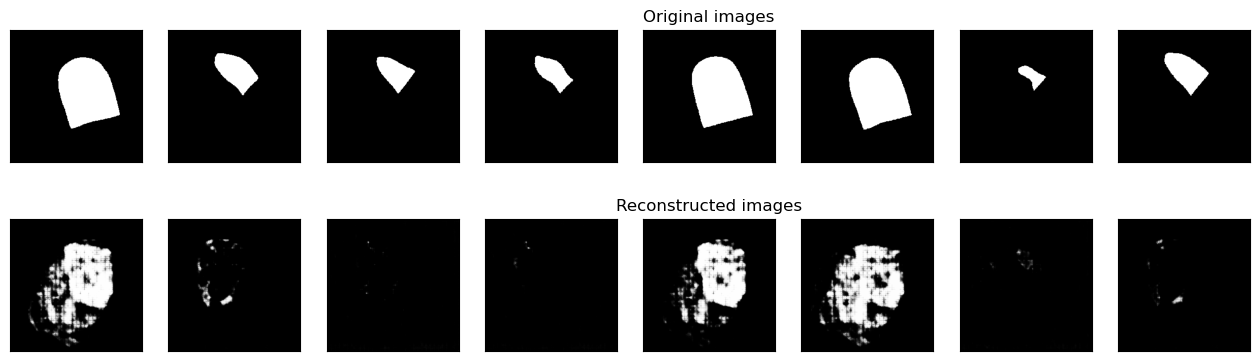


<<<----------------------- EPOCH 12/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9681
Val mean dice: 0.6227

 LV train loss=3559.712 	 and 	 LV val loss=153493.738
Best val DSC: 0.6460 at epoch number of 10


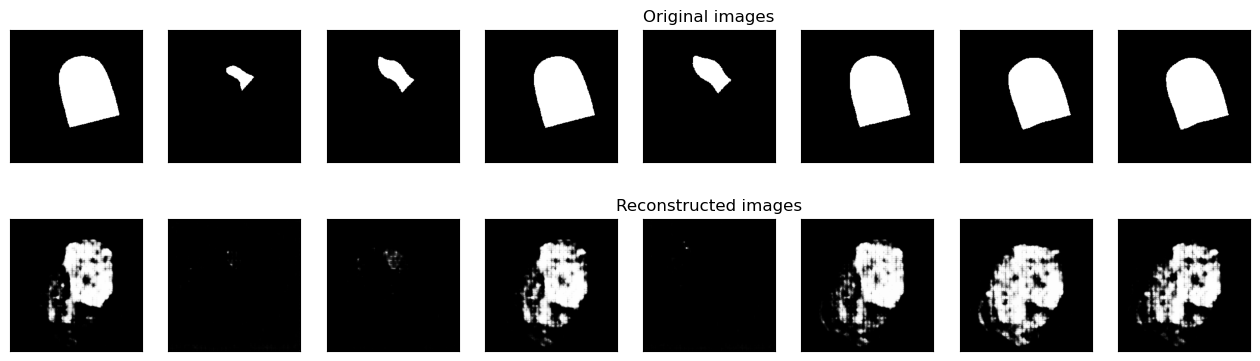


<<<----------------------- EPOCH 13/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9686
Val mean dice: 0.6277

 LV train loss=3519.259 	 and 	 LV val loss=168257.560
Best val DSC: 0.6460 at epoch number of 10


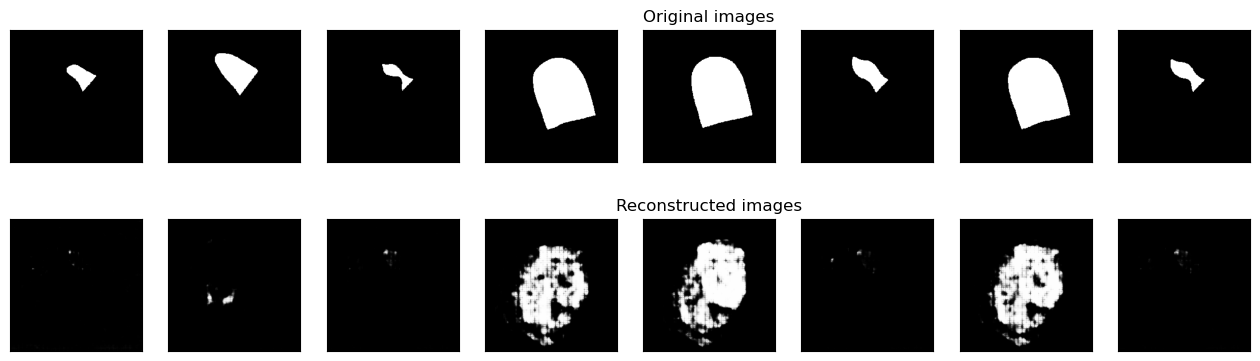


<<<----------------------- EPOCH 14/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9694
Val mean dice: 0.6382

 LV train loss=3365.481 	 and 	 LV val loss=146833.249
Best val DSC: 0.6460 at epoch number of 10


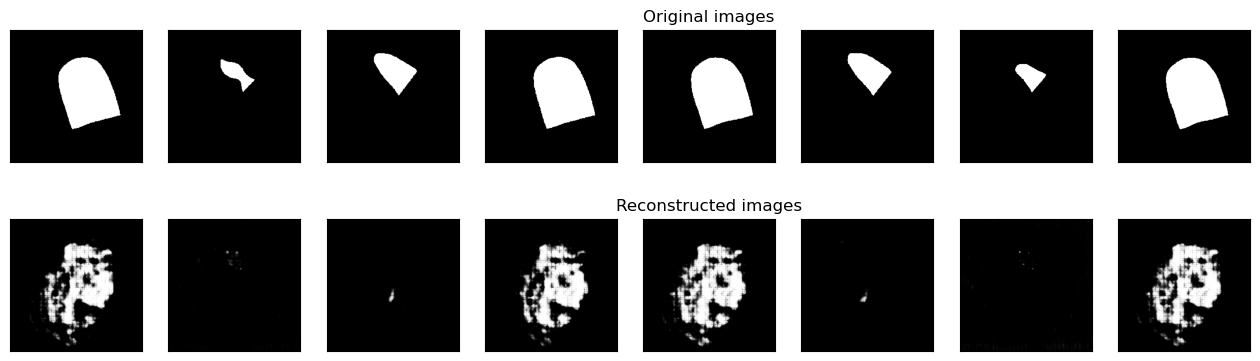


<<<----------------------- EPOCH 15/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9693
Val mean dice: 0.6284

 LV train loss=3367.091 	 and 	 LV val loss=164389.863
Best val DSC: 0.6460 at epoch number of 10


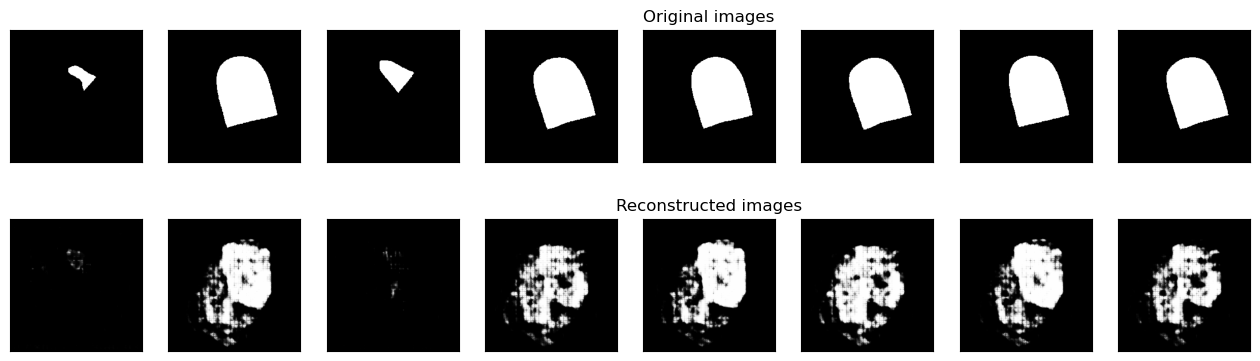


<<<----------------------- EPOCH 16/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9701
Val mean dice: 0.6163

 LV train loss=3261.492 	 and 	 LV val loss=156709.883
Best val DSC: 0.6460 at epoch number of 10


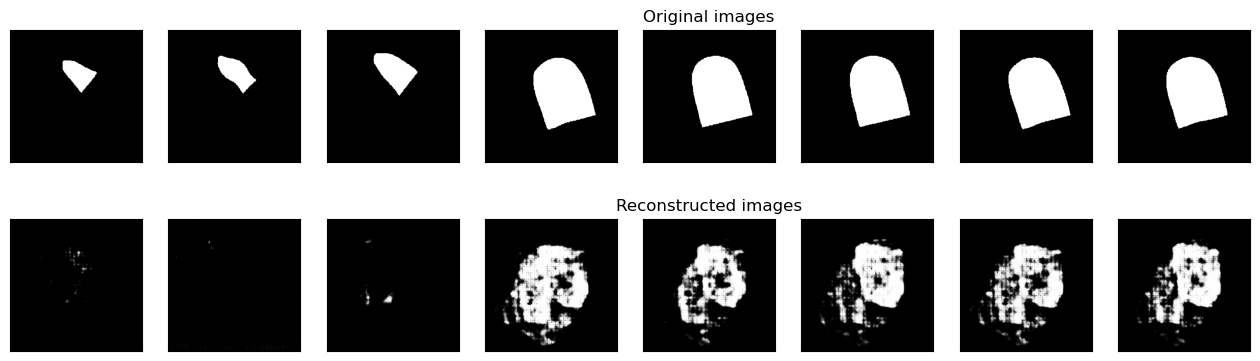


<<<----------------------- EPOCH 17/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9708
Val mean dice: 0.6165

 LV train loss=3214.768 	 and 	 LV val loss=174062.111
Best val DSC: 0.6460 at epoch number of 10


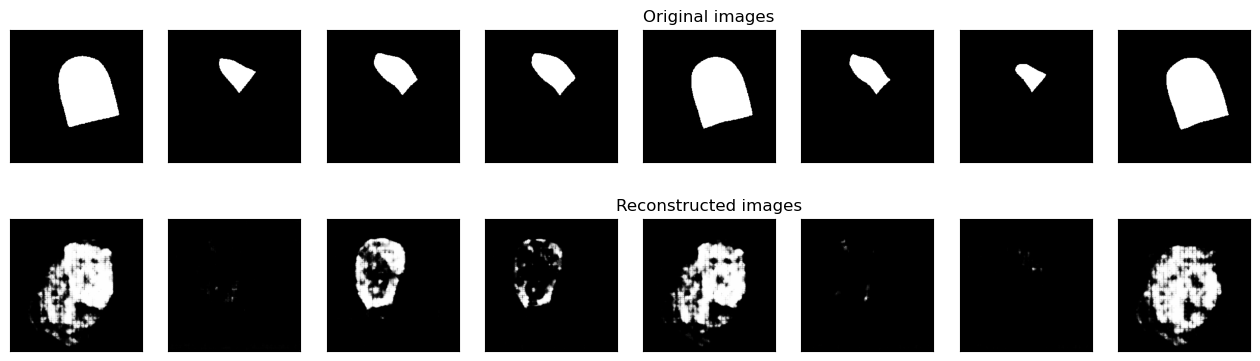


<<<----------------------- EPOCH 18/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9712
Val mean dice: 0.6242

 LV train loss=3178.398 	 and 	 LV val loss=164428.464
Best val DSC: 0.6460 at epoch number of 10


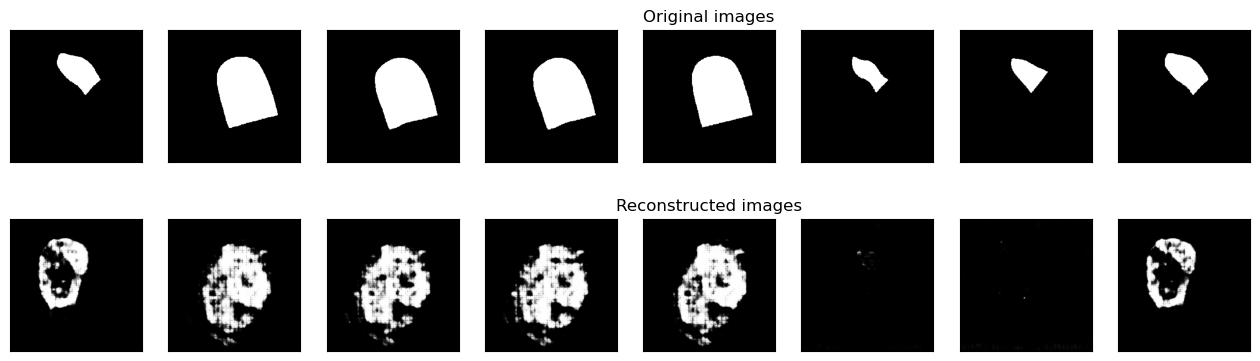


<<<----------------------- EPOCH 19/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9718
Val mean dice: 0.6082

 LV train loss=3099.742 	 and 	 LV val loss=159092.348
Best val DSC: 0.6460 at epoch number of 10


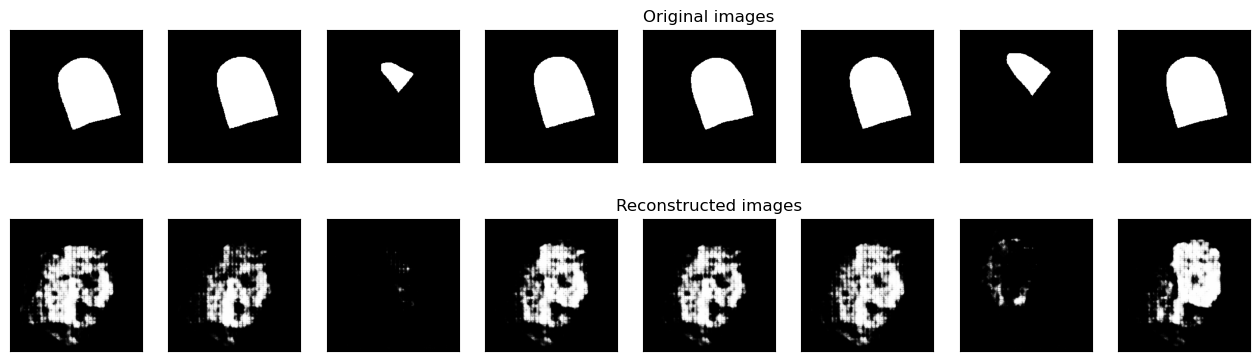


<<<----------------------- EPOCH 20/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9727
Val mean dice: 0.6289

 LV train loss=3058.239 	 and 	 LV val loss=148302.009
Best val DSC: 0.6460 at epoch number of 10


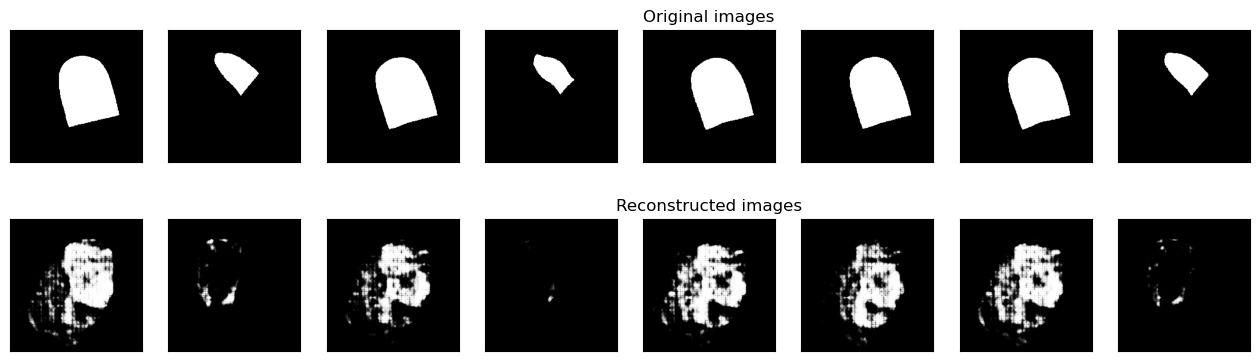


<<<----------------------- EPOCH 21/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9728
Val mean dice: 0.6177

 LV train loss=3113.766 	 and 	 LV val loss=172310.571
Best val DSC: 0.6460 at epoch number of 10


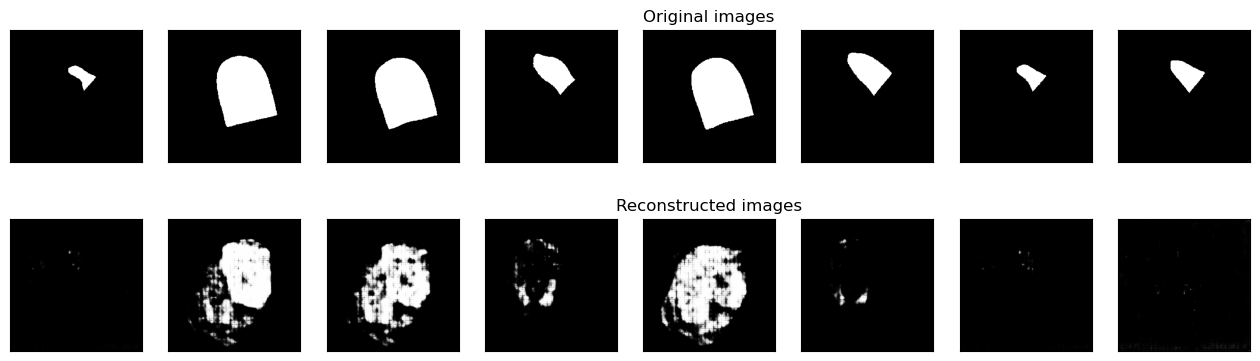


<<<----------------------- EPOCH 22/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9732
Val mean dice: 0.6323

 LV train loss=3019.975 	 and 	 LV val loss=152546.666
Best val DSC: 0.6460 at epoch number of 10


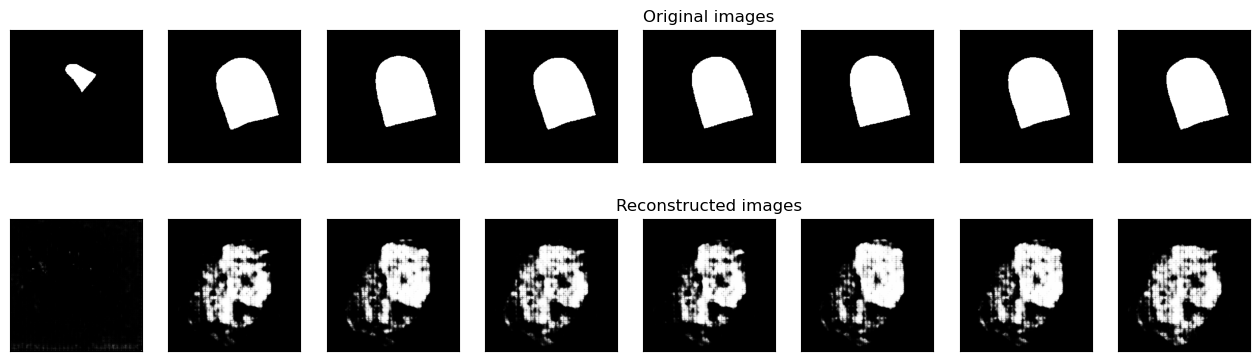


<<<----------------------- EPOCH 23/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9737
Val mean dice: 0.6340

 LV train loss=3052.563 	 and 	 LV val loss=170437.397
Best val DSC: 0.6460 at epoch number of 10


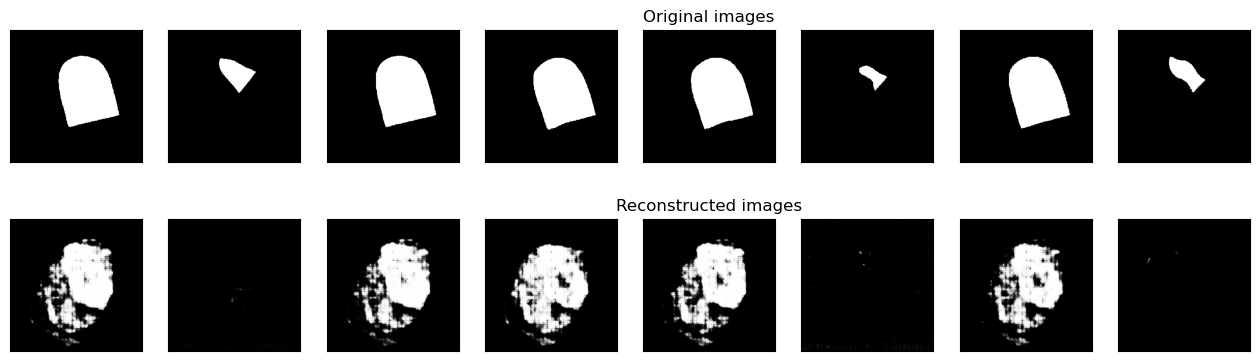


<<<----------------------- EPOCH 24/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9737
Val mean dice: 0.6261

 LV train loss=3170.178 	 and 	 LV val loss=167156.271
Best val DSC: 0.6460 at epoch number of 10


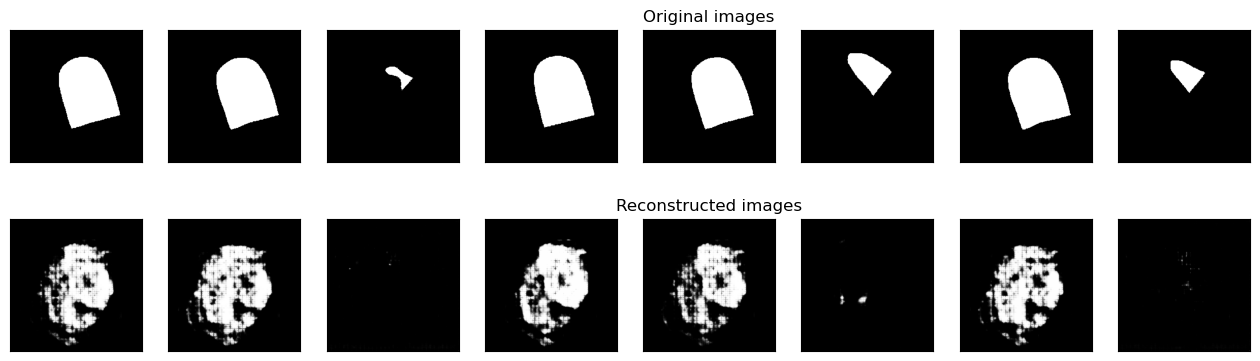


<<<----------------------- EPOCH 25/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9742
Val mean dice: 0.6193

 LV train loss=3221.441 	 and 	 LV val loss=157745.177
Best val DSC: 0.6460 at epoch number of 10


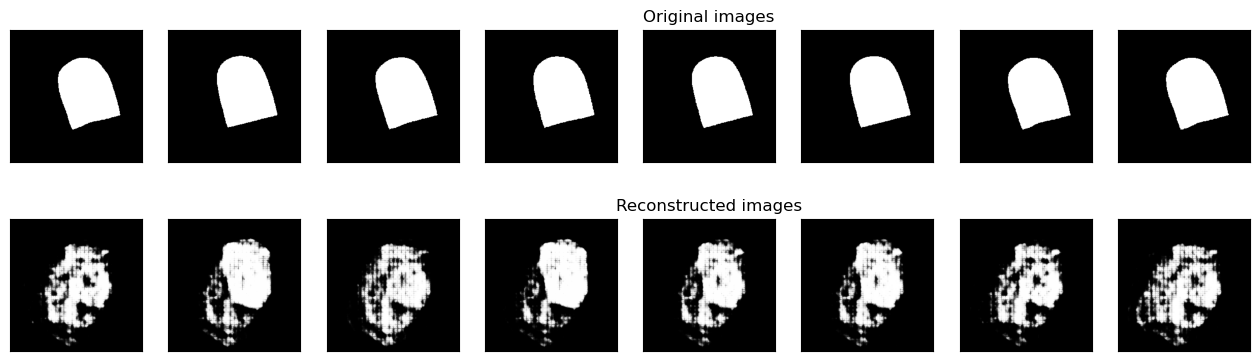


<<<----------------------- EPOCH 26/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9740
Val mean dice: 0.6239

 LV train loss=3273.363 	 and 	 LV val loss=149615.512
Best val DSC: 0.6460 at epoch number of 10


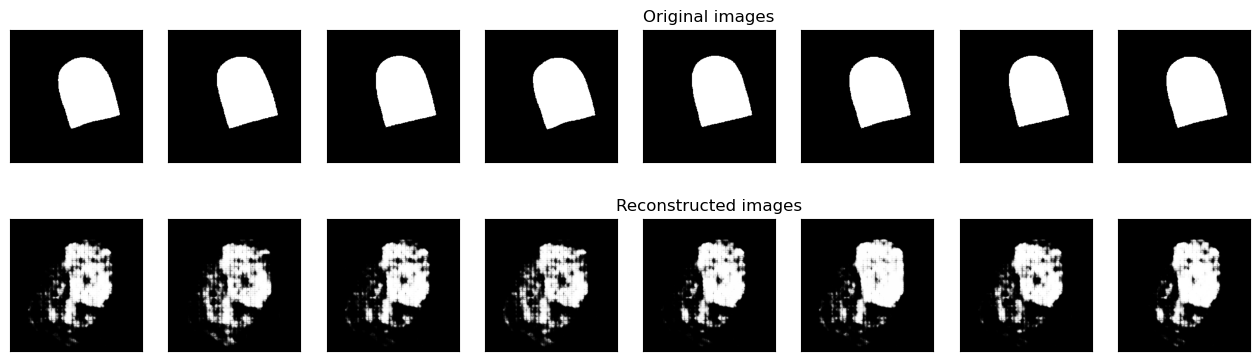


<<<----------------------- EPOCH 27/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9749
Val mean dice: 0.6138

 LV train loss=3031.513 	 and 	 LV val loss=176465.691
Best val DSC: 0.6460 at epoch number of 10


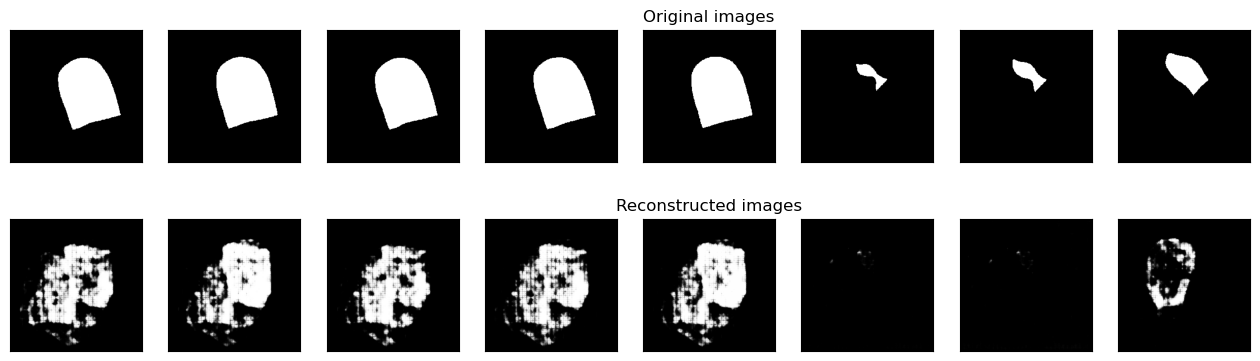


<<<----------------------- EPOCH 28/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9752
Val mean dice: 0.6213

 LV train loss=3010.618 	 and 	 LV val loss=176874.228
Best val DSC: 0.6460 at epoch number of 10


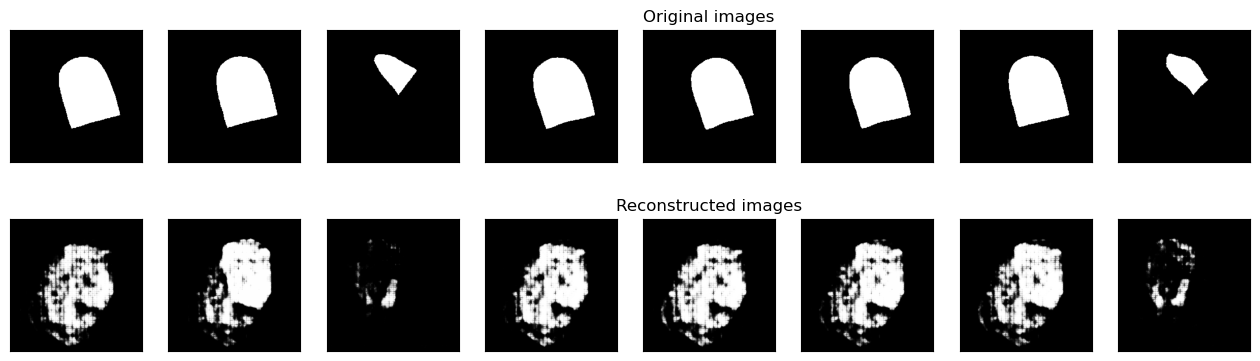


<<<----------------------- EPOCH 29/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9756
Val mean dice: 0.6047

 LV train loss=3006.464 	 and 	 LV val loss=172728.361
Best val DSC: 0.6460 at epoch number of 10


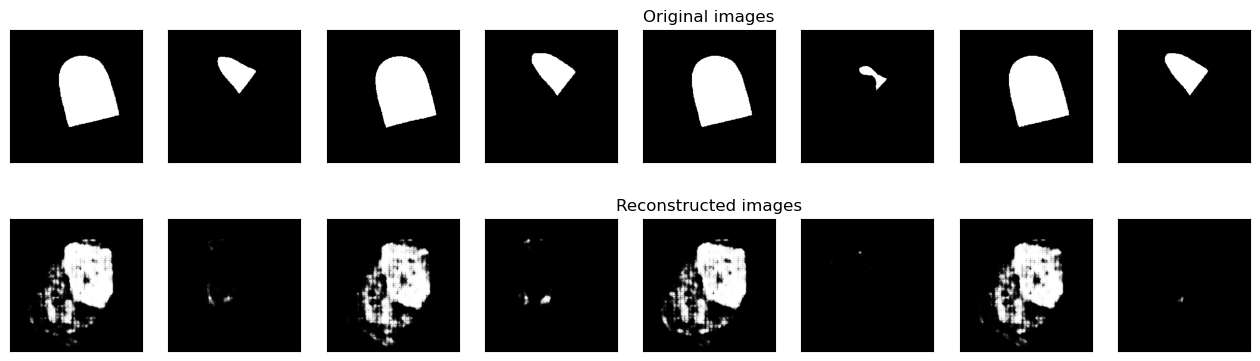


<<<----------------------- EPOCH 30/30 ------------------------->>>
<<<-------------------------- LV ---------------------------->>>
Train mean dice: 0.9762
Val mean dice: 0.6262

 LV train loss=2893.715 	 and 	 LV val loss=165324.332
Best val DSC: 0.6460 at epoch number of 10


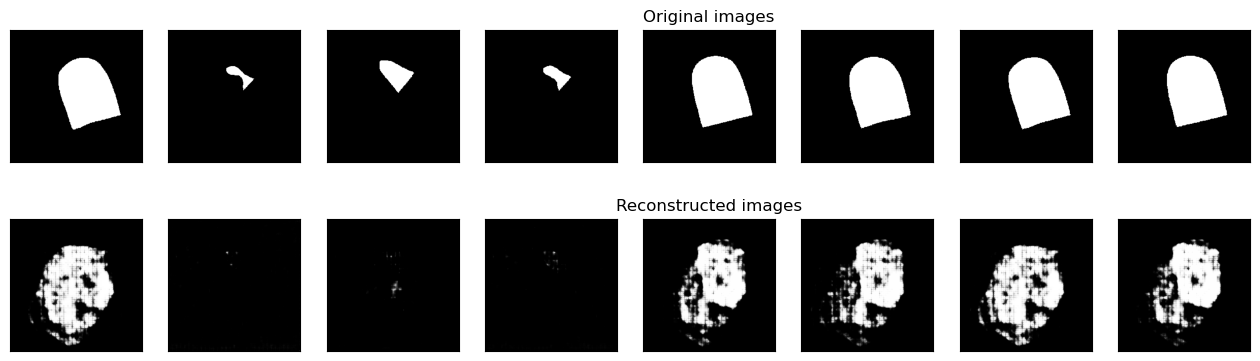

In [29]:
num_epochs = EP

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

train_LV_VAE_loss_ = []
train_LV_loss_DSC_ = []
train_LV_loss_SSIM_ = []
train_LV_loss_KL_ = []
train_LV_loss_diff_loss_ = []

val_LV_VAE_loss_ = []
val_LV_loss_DSC_ = []
val_LV_loss_SSIM_ = []
val_LV_loss_KL_ = []
val_LV_loss_diff_loss_ = []


best_loss = 0

checkpoint_path = 'LV_VAE_3D_v2_'+ str(img_size) + '_' + str(slice_size) + '_.pth'

for epoch in range(num_epochs):
    print('\n<<<----------------------- EPOCH {}/{} ------------------------->>>'.format(epoch + 1, num_epochs))   
    print('<<<-------------------------- LV ---------------------------->>>')
       
    LVtrainLoss = train_epoch(LV_VAE, device, trainData['LV'], optim_LV_VAE)
    LVvalLoss = test_epoch(LV_VAE, device, valData['LV'])
    
    if LVvalLoss[5] > best_loss:
        best_loss_epoch = epoch + 1
        print(f"Valid DSC improved from {best_loss:2.4f} to {LVvalLoss[5]:2.4f}! Best model is saving as---> {checkpoint_path}")
        best_loss = LVvalLoss[5]
        torch.save(LV_VAE.state_dict(), checkpoint_path)
    
    print('\n LV train loss={:.3f} \t and \t LV val loss={:.3f}'.format(LVtrainLoss[0], LVvalLoss[0]))
    
    print(
    f"Best val DSC: {best_loss:.4f} "
    f"at epoch number of {best_loss_epoch}")
       
    train_LV_VAE_loss_.append(LVtrainLoss[0])
    train_LV_loss_DSC_.append(LVtrainLoss[1])
    train_LV_loss_SSIM_.append(LVtrainLoss[2])
    train_LV_loss_KL_.append(LVtrainLoss[3])
    train_LV_loss_diff_loss_.append(LVtrainLoss[4])
    
    val_LV_VAE_loss_.append(LVvalLoss[0])
    val_LV_loss_DSC_.append(LVvalLoss[1])
    val_LV_loss_SSIM_.append(LVvalLoss[2])
    val_LV_loss_KL_.append(LVvalLoss[3])
    val_LV_loss_diff_loss_.append(LVvalLoss[4])

    plot_outputs(LV_VAE.encoder, LV_VAE.decoder, valData['LV'])

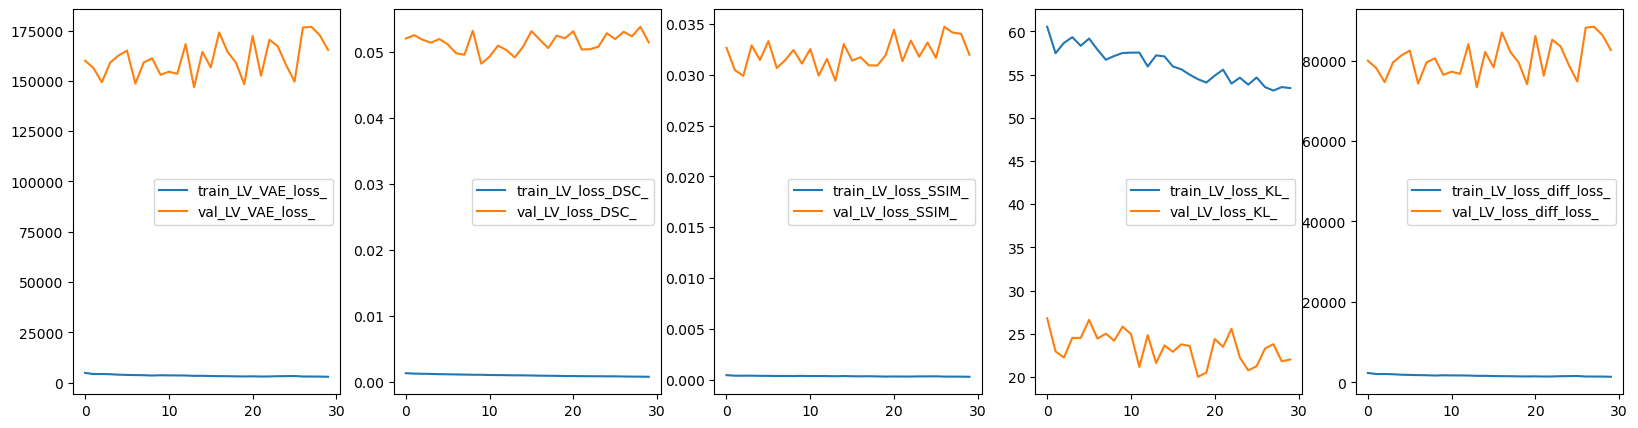

In [30]:
# plot and save the generator and discriminator loss
plt.figure("LV", (20, 5))
plt.subplot(151)
plt.plot(train_LV_VAE_loss_, label='train_LV_VAE_loss_')
plt.plot(val_LV_VAE_loss_, label='val_LV_VAE_loss_')
plt.legend()

plt.subplot(152)
plt.plot(train_LV_loss_DSC_, label='train_LV_loss_DSC_')
plt.plot(val_LV_loss_DSC_, label='val_LV_loss_DSC_')
plt.legend()

plt.subplot(153)
plt.plot(train_LV_loss_SSIM_, label='train_LV_loss_SSIM_')
plt.plot(val_LV_loss_SSIM_, label='val_LV_loss_SSIM_')
plt.legend()

plt.subplot(154)
plt.plot(train_LV_loss_KL_, label='train_LV_loss_KL_')
plt.plot(val_LV_loss_KL_, label='val_LV_loss_KL_')
plt.legend()

plt.subplot(155)
plt.plot(train_LV_loss_diff_loss_, label='train_LV_loss_diff_loss_')
plt.plot(val_LV_loss_diff_loss_, label='val_LV_loss_diff_loss_')
plt.legend()